In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load data
match_rep_df = pd.read_csv("checkpoints/match_rep_df.csv")
match_rep_df.columns

Index(['Unnamed: 0', 'Vendor', 'Batch', 'Plate_Map_Name',
       'Assay_Plate_Barcode', 'Modality', 'Images_per_well',
       'Sites-SubSampled_x', 'Binning', 'Magnification', 'Number_of_channels',
       'z_plane', 'BF_Zplanes', 'Anomaly', 'spinning-disc', 'aperture',
       'dry-immersion', 'vs-brightfield', 'simultaneous-excitation', 'sites',
       'Replicating', 'Null_Replicating', 'Percent_Replicating',
       'value_95_replicating', 'sphering', 'cell_count', 'Sites-SubSampled_y',
       'Matching', 'Null_Matching', 'Percent_Matching', 'value_95_matching'],
      dtype='object')

# Assessing profiles

Do some profiles have more of an influence over others? How can you find the outliers? https://biocellgen-public.svi.edu.au/mig_2019_scrnaseq-workshop/quality-control-and-data-visualisation.html 

Ideas:
- Box plots, label >95th outliers
- Histogram of total cell counts
- Histogram of number of input features after feature selection
- Some sort of ratio between features:perc replicating?

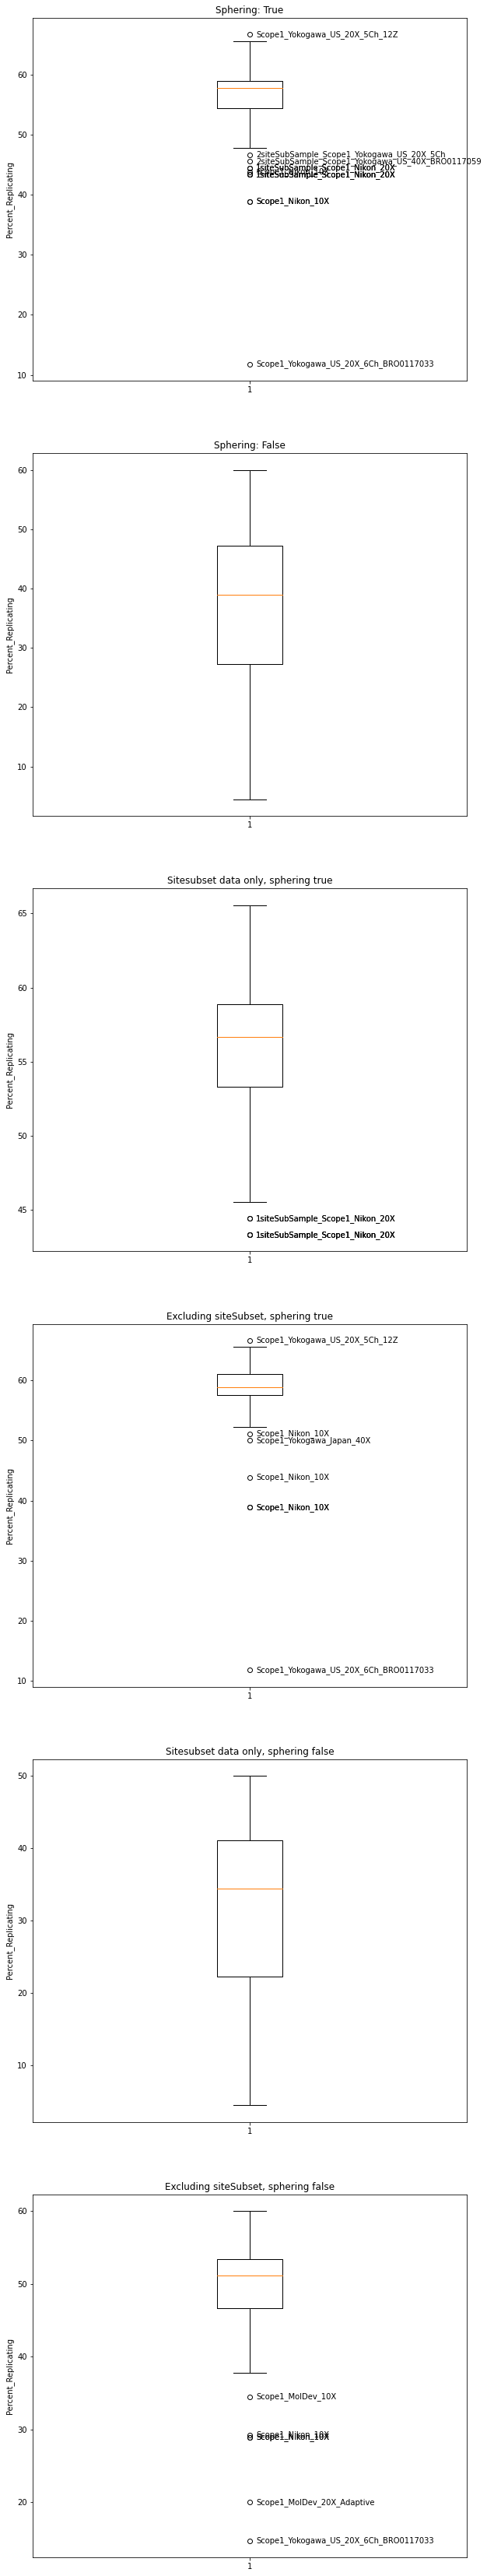

In [7]:
# Boxplot and print outliers

class BoxPlot:
    def __init__(self, df, x, ax):
        self.df = df
        self.x = x
        self.ax = ax

    def make_labels(self, boxplot):
        """
        Modified from: https://stackoverflow.com/questions/55648729/python-how-to-print-the-box-whiskers-and-outlier-values-in-box-and-whisker-plo
        """

        # Grab the relevant Line2D instances from the boxplot dictionary
        iqr = boxplot['boxes'][0]
        caps = boxplot['caps']
        med = boxplot['medians'][0]
        fly = boxplot['fliers'][0]

        # The x position of the median line
        xpos = med.get_xdata()

        # Lets make the text have a horizontal offset which is some 
        # fraction of the width of the box
        xoff = 0.10 * (xpos[1] - xpos[0])

        # Many fliers, so we loop over them and create a label for each one
        for i, flier in enumerate(fly.get_ydata()):
            right_or_left = i % 2
            offset = -abs(1+xoff) if right_or_left else 1+xoff
            self.ax.text(1 + xoff, flier,
                    '{}'.format(self.df[self.df[self.x] == flier]["Batch"].values[0]), va='center')
            # print(self.df[self.df[self.x] == flier]["Batch"].values[0])
            # self.ax.text(offset, flier,
            #         '{}'.format(self.df[self.df[self.x] == flier]["Batch"].values[0]), va='center')

    def boxplot_outliers(self, title):
        boxplot = self.ax.boxplot(
            self.df[self.x]
        )
        self.ax.set_ylabel(self.x)
        self.ax.set_title(title)
        self.make_labels(boxplot)
        fig.set_facecolor("white")

df_list = {"Sphering: True": match_rep_df[match_rep_df["sphering"]==True],
           "Sphering: False": match_rep_df[match_rep_df["sphering"]==False],
           "Sitesubset data only, sphering true": match_rep_df[(match_rep_df["Batch"].str.contains("siteSub")) & (match_rep_df["sphering"] == True)],
           "Excluding siteSubset, sphering true": match_rep_df[(~match_rep_df["Batch"].str.contains("siteSub")) & (match_rep_df["sphering"] == True)],
           "Sitesubset data only, sphering false": match_rep_df[(match_rep_df["Batch"].str.contains("siteSub")) & (match_rep_df["sphering"] == False)],
           "Excluding siteSubset, sphering false": match_rep_df[(~match_rep_df["Batch"].str.contains("siteSub")) & (match_rep_df["sphering"] == False)]
        }

fig, ax_ = plt.subplots(len(df_list), figsize=(10, len(df_list) * 10))

for ax, (title, df) in zip(ax_.flatten(), df_list.items()):
    BoxPlot(df, "Percent_Replicating", ax).boxplot_outliers(title)

fig.savefig("figures/boxplot-for-subsets.png", bbox_inches="tight", dpi=300)
